In [1]:
# automatically reload dependencies and repository content so that kernel need not be restarted
%load_ext autoreload
%autoreload 2

In [2]:
import torch


device = None
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda:0")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using GPU


In [3]:
from image_dataset import ImageDataset
from data_augmentation import DataAugmentation

dataAugmentation = DataAugmentation()
dataset = ImageDataset(dataAugmentation = dataAugmentation)

In [4]:
trainIds = range(1,19001)

In [5]:
from data_balancer import DataBalancer

dataBalancer = DataBalancer()

trainIds = dataBalancer.balanceData(trainIds, 80000-19000, trainIds)

In [6]:
trainDataset = ImageDataset(trainIds, dataAugmentation=dataAugmentation)
valDataset = ImageDataset(range(19001,20001))

In [10]:
from reseption_net import ReseptionNet
from convolution_components import BasicConv2d, MaxPooling, IdentityConv2d

torch.cuda.empty_cache()

basicInceptionConfig = {
    "branches": [
        {
            "blocks": [
                {
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 3,
                    "kernelSize": 3,
                    "padding": 1,
                    "stride": 1,
                    "dilation": 1,
                    "grouping": True,
                },
                {   
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 1,
                    "kernelSize": 4,
                    "padding": 0,
                    "stride": 4,
                    "dilation": 1,
                    "grouping": True,
                }
            ]
        },
        {
            "blocks": [
                {
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 3,
                    "kernelSize": 5,
                    "padding": 2,
                    "stride": 1,
                    "dilation": 1,
                    "grouping": True,
                },
                {   
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 1,
                    "kernelSize": 4,
                    "padding": 0,
                    "stride": 4,
                    "dilation": 1,
                    "grouping": True,
                }
            ]
        },
        {
            "blocks": [
                {
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 3,
                    "kernelSize": 7,
                    "padding": 3,
                    "stride": 1,
                    "dilation": 1,
                    "grouping": True,
                },
                {   
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 1,
                    "kernelSize": 4,
                    "padding": 0,
                    "stride": 4,
                    "dilation": 1,
                    "grouping": True,
                }
            ]
        }
        
    ],
    "shortcut": {
        "convolution": IdentityConv2d,
        "kernelSize": 1,
        "padding": 0,
        "stride": 4,
        "dilation": 1,
        "grouping": True,
    }
}

combinerConfig = {
    "branches": [
        {
            "blocks": [
                {
                    "convolution": BasicConv2d,
                    "outputChannelMultiplier": 1,
                    "kernelSize": 7,
                    "padding": 0,
                    "stride": 7,
                    "dilation": 1,
                    "grouping": True,
                }
            ]
        }
    ],
    "shortcut": {
        "convolution": IdentityConv2d,
        "kernelSize": 1,
        "padding": 0,
        "stride": 7,
        "dilation": 1,
        "grouping": True,
    }
}
    
config = {
    "inceptions": [
        {
            "config": basicInceptionConfig,
            "amount": 2,
        },
        {
            "config": combinerConfig,
            "amount": 1,
        },
    ],
    "inChannels": 3,
    "inDimensions": (224, 224),
    "outputs": 14,
}

model = ReseptionNet(device, config)
print("Parameters:", model.getNumberOfParameters())

inception 1 iteration 1 layer output dimensions 27 * 56 * 56 = 84672
inception 1 iteration 2 layer output dimensions 243 * 14 * 14 = 47628
inception 2 iteration 1 layer output dimensions 243 * 2 * 2 = 972
Parameters: 38885


In [ ]:
model.load_state_dict(torch.load("shallow_model.pkl"))

In [ ]:
from train_model import train_model

model = train_model(
    model,
    trainDataset,
    valDataset,
    device,
    numberOfEpochs = 1
)

Epoch 1/1
----------
Training...

Progress: 31%

In [34]:
torch.save(model.state_dict(), 'shallow_model.pkl')
#torch.cuda.empty_cache()

In [35]:
import eval_model

decisionThreshold = 0.5

yHats, yTrues = eval_model.test_model(model, valDataset, device, decisionThreshold=decisionThreshold)
for metric in ['precision', 'recall', 'f1', 'accuracy']:
    print("{}: {}".format(metric, eval_model.get_metric(yTrues, yHats, metric)))

precision: 0.34146341463414637
recall: 0.2246740220661986
f1: 0.2710223835450696
accuracy: 0.9139285714285714


Validation images:



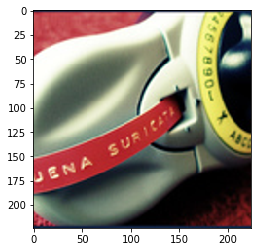

True labels:  []
Predicted labels: []



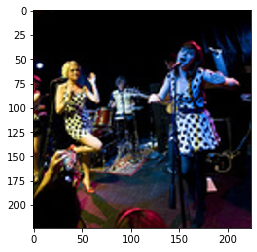

True labels:  ['people', 'female']
Predicted labels: []



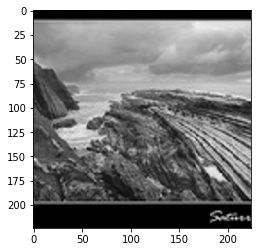

True labels:  []
Predicted labels: []



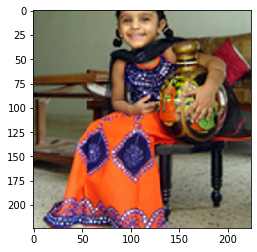

True labels:  ['portrait', 'people', 'female']
Predicted labels: ['flower']



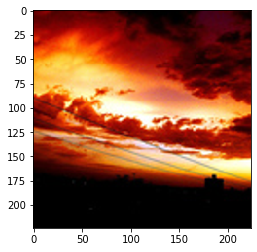

True labels:  ['clouds']
Predicted labels: ['flower']



In [36]:
from example_prediction_shower import showExamplePredictions

print("Validation images:")
print()
showExamplePredictions(model, valDataset, device, 5, decisionThreshold=decisionThreshold)

Training images:



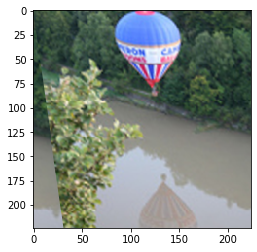

True labels:  ['river']
Predicted labels: []



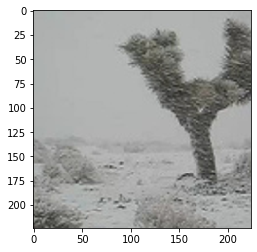

True labels:  ['tree']
Predicted labels: []



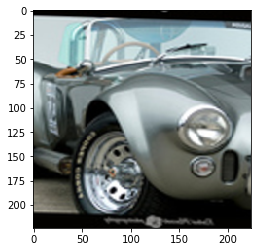

True labels:  ['car']
Predicted labels: []



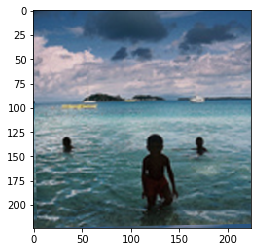

True labels:  ['clouds', 'male', 'people', 'sea']
Predicted labels: ['sea']



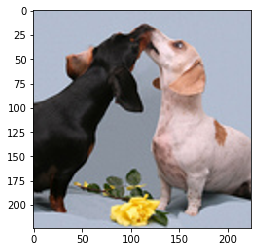

True labels:  ['dog']
Predicted labels: ['flower']



In [37]:
print("Training images:")
print()
showExamplePredictions(model, trainDataset, device, 5, decisionThreshold=decisionThreshold)